In [2]:
import os
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.optim as optim
import torchvision.transforms as standard_transforms
from skimage import io, transform
from sklearn.model_selection import train_test_split

import numpy as np
import glob
import os


from matplotlib import pyplot as plt
from u2net import U2NET

from PIL import Image

import time
import datetime

from PIL import ImageFile

In [324]:
def random_rotate(img, mask):
    angle = np.random.randint(-45, 45)

    return T.functional.rotate(img, angle), T.functional.rotate(mask, angle)


In [323]:
def random_flip(img, mask):
    mode = np.random.randint(0, 2)
    if mode == 0:
        return T.functional.vflip(img), T.functional.vflip(mask)
    elif mode == 1:
        return T.functional.hflip(img), T.functional.hflip(mask)

In [3]:
def make_affine(image, mask):
    '''
    :param image: torch tensor (h,w,c)
    :param angle: rotation degree
    :param translate: x and y offset
    :param scale: image zoom
    :param shear: diagonal stretching
    :return: torch tensor
    '''

    # угол наклона
    angle = np.random.randint(-45, 45)

    # сдвиг по оси х и у
    translate = (np.random.randint(-image.size()[0] // 4, image.size()[0] // 4),
                 np.random.randint(-image.size()[1] // 4, image.size()[1] // 4))

    # приближение
    scale = np.random.uniform(0.3, 1)

    # диагональное растяжение
    shear = (1, 1)

    img = torch.transpose(image, 0, 2)
    msk = torch.stack([mask, mask, mask], 2).transpose(0, 2)

    res_img = T.functional.affine(img, angle=angle, translate=translate, scale=scale, shear=shear)
    res_mask = T.functional.affine(msk, angle=angle, translate=translate, scale=scale, shear=shear)

    return res_img.transpose(0, 2), res_mask.transpose(0, 2)

In [4]:
def random_color_jitter(image):
    img = image.transpose(0, 2)
    res = T.ColorJitter(brightness=0.3, hue=0.3)(img)
    return res.transpose(0, 2)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
images = []
masks = []

images_path = 'data/image/'
masks_path = 'data/semantic_label/'
img_size=700

for path in glob.glob(images_path + '*'):
    img_tensor=torch.from_numpy(io.imread(path))
    img_resized=T.Resize((img_size,img_size))(img_tensor).to(device)
    images.append(img_resized)

for path in glob.glob(masks_path + '*'):
    mask_tensor=torch.from_numpy(io.imread(path))
    mask_resized=T.Resize((img_size,img_size))(mask_tensor).to(device)
    masks.append(mask_resized)

images=np.array(images)
masks=np.array(masks)


KeyboardInterrupt: 

<ipython-input-5-8c1c3cedd4f7>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  images=np.array(images)


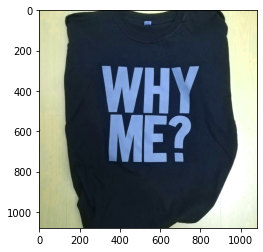

In [353]:


image = images[0]
mask = masks[0]

img1 = torch.from_numpy(image)
mask1 = torch.from_numpy(mask)

img = img1.transpose(0, 2)
# msk = torch.stack([mask1, mask1, mask1], 2).transpose(0, 2)

# preproc = T.functional.affine(msk, angle=0, translate=[0, 0], scale=1, shear=[1, 1]).transpose(0, 2)

preproc = T.ColorJitter(brightness=0.3, hue=0.3)(img).transpose(0, 2)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# i, m = make_affine(img1, mask1)
# ax1.imshow(i)
# ax2.imshow(m)
plt.imshow(preproc)
#plt.imshow(preproc)
plt.show()

In [327]:
img1.size()

torch.Size([1080, 1080, 3])

In [ ]:
RescaleT(700),
T.ColorJitter(brightness=.5, contrast=.5, saturation=.5, hue=.5),
T.RandomHorizontalFlip(p=0.5),
T.RandomVerticalFlip(p=0.5),
T.RandomRotation(degrees=(0, 180))

In [33]:
bce_loss = nn.BCELoss(size_average=True)


def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v):
    loss0 = bce_loss(d0, labels_v)
    loss1 = bce_loss(d1, labels_v)
    loss2 = bce_loss(d2, labels_v)
    loss3 = bce_loss(d3, labels_v)
    loss4 = bce_loss(d4, labels_v)
    loss5 = bce_loss(d5, labels_v)
    loss6 = bce_loss(d6, labels_v)

    loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    # print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n" % (
    #     loss0.data.item(), loss1.data.item(), loss2.data.item(), loss3.data.item(), loss4.data.item(),
    #     loss5.data.item(),
    #     loss6.data.item()))

    return loss0, loss

In [6]:
model_name = f'u2net_{datetime.datetime.now().date()}'

images_path = 'data/image/'
masks_path = 'data/semantic_label/'

model_dir = 'saved_models/' + model_name



In [36]:
net = U2NET(3, 1)
if torch.cuda.is_available():
    net.cuda()

In [38]:

ite_num = 0
running_loss = 0.0
running_tar_loss = 0.0
ite_num4val = 0
save_frq = 2000  # save the model every 2000 iterations

epoch_num = 1000
batch_size_train = 24
train_num = len(tra_img_name_list)
batch_size_val = 1
val_num = 0

salobj_dataloader = DataLoader(salobj_dataset, batch_size=batch_size_train, shuffle=True, num_workers=1)

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

for epoch in range(0, epoch_num):
    net.train()

    for i, data in enumerate(salobj_dataloader):
        ite_num = ite_num + 1
        ite_num4val = ite_num4val + 1

        inputs, labels = data['image'], data['label']

        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)

        # wrap them in Variable
        if torch.cuda.is_available():
            inputs_v, labels_v = Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(),
                                                                                        requires_grad=False)
        else:
            inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)

        # y zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        d0, d1, d2, d3, d4, d5, d6 = net(inputs_v)
        loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v)

        loss.backward()
        optimizer.step()

        # # print statistics
        running_loss += loss.data.item()

        # del temporary outputs and loss
        del d0, d1, d2, d3, d4, d5, d6, loss2, loss

        print(
            f"epoch: {epoch + 1}/{epoch_num}, batch: {(i + 1) * batch_size_train}/{train_num}, ite: {ite_num} train loss: {running_loss / ite_num4val} ")

        if ite_num % save_frq == 0:
            torch.save(net.state_dict(), model_dir + model_name + "_bce_itr_%d_train_%3f_tar_%3f.pth" % (
                ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val))
            running_loss = 0.0
            running_tar_loss = 0.0
            net.train()  # resume train
            ite_num4val = 0


epoch: 1/1000, batch: 24/4024, ite: 1 train loss: 2.136038303375244 
epoch: 1/1000, batch: 48/4024, ite: 2 train loss: 2.7362329959869385 
epoch: 1/1000, batch: 72/4024, ite: 3 train loss: 2.462747891743978 
epoch: 1/1000, batch: 96/4024, ite: 4 train loss: 2.3425833880901337 
epoch: 1/1000, batch: 120/4024, ite: 5 train loss: 2.2762691736221314 
epoch: 1/1000, batch: 144/4024, ite: 6 train loss: 2.1904390255610147 
epoch: 1/1000, batch: 168/4024, ite: 7 train loss: 2.130296298435756 
epoch: 1/1000, batch: 192/4024, ite: 8 train loss: 2.1250045597553253 
epoch: 1/1000, batch: 216/4024, ite: 9 train loss: 2.1028853787316217 
epoch: 1/1000, batch: 240/4024, ite: 10 train loss: 2.0659117221832277 
epoch: 1/1000, batch: 264/4024, ite: 11 train loss: 2.0404987226833 
epoch: 1/1000, batch: 288/4024, ite: 12 train loss: 2.0281540354092917 
epoch: 1/1000, batch: 312/4024, ite: 13 train loss: 1.999640024625338 
epoch: 1/1000, batch: 336/4024, ite: 14 train loss: 1.9748997858592443 
epoch: 1/100

KeyboardInterrupt: 